In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from torchvision import transforms, datasets
from PIL import Image, ImageFile
from tqdm import tqdm_notebook
from torchsummary import summary
import time
import glob
import importlib

import data
importlib.reload(data)
import autoencoder
importlib.reload(autoencoder)
from autoencoder import AutoEncoder

In [2]:
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)

USING_GPU = True
if torch.cuda.is_available():
    device = torch.device("cuda")
    torch.set_default_tensor_type('torch.cuda.FloatTensor')
elif torch.backends.mps.is_available():
    device = torch.device("mps")
    torch.set_default_device(device)
else:
    device = torch.device("cpu")
    USING_GPU = False


In [3]:
IMAGE_SIZE = 224
BATCH_SIZE = 8
DATASET_PATH = './data/train/'

train_ds = data.get_dataset(DATASET_PATH, IMAGE_SIZE)
train_dl = data.get_dataloader(train_ds, BATCH_SIZE, shuffle=False)

In [4]:
channel_sizes = [4, 8, 16]
layer_sizes = [112, 56, 28]
autoencoder = AutoEncoder(layer_sizes, channel_sizes, input_size=IMAGE_SIZE).to(device)
autoencoder = autoencoder.cpu()
summary(autoencoder, (3, IMAGE_SIZE, IMAGE_SIZE), device='cpu')
autoencoder = autoencoder.to(device)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 4, 224, 224]             112
              ReLU-2          [-1, 4, 224, 224]               0
         MaxPool2d-3          [-1, 4, 112, 112]               0
            Conv2d-4          [-1, 8, 112, 112]             296
              ReLU-5          [-1, 8, 112, 112]               0
         MaxPool2d-6            [-1, 8, 56, 56]               0
            Conv2d-7           [-1, 16, 56, 56]           1,168
              ReLU-8           [-1, 16, 56, 56]               0
         MaxPool2d-9           [-1, 16, 28, 28]               0
           Conv2d-10           [-1, 16, 28, 28]           2,320
          Flatten-11                [-1, 12544]               0
          Reshape-12           [-1, 16, 28, 28]               0
           Conv2d-13           [-1, 16, 28, 28]           2,320
             ReLU-14           [-1, 16,

In [5]:
def train_net(net: torch.nn.Module, train_dl: torch.utils.data.DataLoader, num_epochs: int, lr: float):
    """
    Trains the network on the given dataset
    :param net: The network to train
    :param train_dl: The dataloader for the training dataset
    :param num_epochs: The number of epochs to train for
    :param lr: The learning rate to use
    :return: None
    """
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    loss_fn = torch.nn.MSELoss()
    net.to(device)
    loss_hist = []
    # Start training
    start_time = time.time()
    for epoch in range(num_epochs):
        epoch_loss = 0.0
        sliding_loss = 0.0
        SLIDING_WINDOW = 500
        for i, (images, _) in enumerate(tqdm_notebook(train_dl)):
            images = images.to(device)
            optimizer.zero_grad()
            outputs = net(images)
            loss = loss_fn(outputs, images)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
            sliding_loss += loss.item()
            if i % SLIDING_WINDOW == SLIDING_WINDOW - 1:
                print("=========================================")
                print(f"Epoch progress: {i / len(train_dl) * 100:.2f}%")
                print(f"Time taken: {time.time() - start_time:.3f}s")
                print(f"Estimated time left: {(time.time() - start_time) / (i + 1) * (len(train_dl) - i - 1):.3f}s")
                print(f"  training loss (sliding): \t{sliding_loss / SLIDING_WINDOW:.6f}")
                print("=========================================")
                sliding_loss = 0.0
        loss_hist.append(epoch_loss)
        print(f"Epoch {epoch + 1} of {num_epochs} took {time.time() - start_time:.3f}s")
        print(f"  training loss (in-iteration): \t{epoch_loss:.6f}")
        eta = (time.time() - start_time) / (epoch + 1) * (num_epochs - epoch - 1)
        print(f"  estimated time left: \t\t{eta:.3f}s")
    return loss_hist

In [6]:
# Set the number of epochs and learning rate
NUM_EPOCHS = 5
LEARNING_RATE = 1e-3

In [7]:
# Train the network
loss_hist = train_net(autoencoder, train_dl, NUM_EPOCHS, LEARNING_RATE)

/var/folders/_5/tswfwkss0k1c6sfrrhpfkpkr0000gn/T/ipykernel_8074/2090251066.py:20: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i, (images, _) in enumerate(tqdm_notebook(train_dl)):


  0%|          | 0/14786 [00:00<?, ?it/s]

/Users/maheshjayasankar/Documents/Style-Transfer/.venv/lib/python3.11/site-packages/torch/utils/_device.py:62: UserWarning: The operator 'aten::random_' is not currently supported on the MPS backend and will fall back to run on the CPU. This may have performance implications. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/mps/MPSFallback.mm:11.)
  return func(*args, **kwargs)


Epoch progress: 16.87%
Time taken: 18.271s
Estimated time left: 522.029s
  training loss (sliding): 	0.054777
Epoch progress: 33.78%
Time taken: 33.361s
Estimated time left: 459.915s
  training loss (sliding): 	0.014208
Epoch progress: 50.69%
Time taken: 48.651s
Estimated time left: 430.922s
  training loss (sliding): 	0.012642
Epoch progress: 67.60%
Time taken: 63.613s
Estimated time left: 406.681s
  training loss (sliding): 	0.008059
Epoch progress: 84.51%
Time taken: 78.420s
Estimated time left: 385.387s
  training loss (sliding): 	0.007662
Epoch progress: 101.41%
Time taken: 93.338s
Estimated time left: 366.694s
  training loss (sliding): 	0.007223
Epoch progress: 118.32%
Time taken: 108.163s
Estimated time left: 348.780s
  training loss (sliding): 	0.006895
Epoch progress: 135.23%
Time taken: 123.026s
Estimated time left: 331.738s
  training loss (sliding): 	0.006439
Epoch progress: 152.14%
Time taken: 138.036s
Estimated time left: 315.519s
  training loss (sliding): 	0.006109
Epo

  0%|          | 0/14786 [00:00<?, ?it/s]

Epoch progress: 16.87%
Time taken: 492.066s
Estimated time left: 14059.299s
  training loss (sliding): 	0.005082
Epoch progress: 33.78%
Time taken: 507.849s
Estimated time left: 7001.200s
  training loss (sliding): 	0.004954
Epoch progress: 50.69%
Time taken: 523.681s
Estimated time left: 4638.414s
  training loss (sliding): 	0.004984
Epoch progress: 67.60%
Time taken: 539.594s
Estimated time left: 3449.623s
  training loss (sliding): 	0.004913
Epoch progress: 84.51%
Time taken: 555.511s
Estimated time left: 2730.005s
  training loss (sliding): 	0.004995
Epoch progress: 101.41%
Time taken: 571.583s
Estimated time left: 2245.557s
  training loss (sliding): 	0.004936
Epoch progress: 118.32%
Time taken: 587.578s
Estimated time left: 1894.689s
  training loss (sliding): 	0.004830
Epoch progress: 135.23%
Time taken: 603.705s
Estimated time left: 1627.890s
  training loss (sliding): 	0.004920
Epoch progress: 152.14%
Time taken: 619.824s
Estimated time left: 1416.781s
  training loss (sliding

  0%|          | 0/14786 [00:00<?, ?it/s]

Epoch progress: 16.87%
Time taken: 981.448s
Estimated time left: 28041.943s
  training loss (sliding): 	0.004670
Epoch progress: 33.78%
Time taken: 997.333s
Estimated time left: 13749.235s
  training loss (sliding): 	0.004572
Epoch progress: 50.69%
Time taken: 1013.354s
Estimated time left: 8975.616s
  training loss (sliding): 	0.004645
Epoch progress: 67.60%
Time taken: 1029.353s
Estimated time left: 6580.651s
  training loss (sliding): 	0.004524
Epoch progress: 84.51%
Time taken: 1045.530s
Estimated time left: 5138.155s
  training loss (sliding): 	0.004625
Epoch progress: 101.41%
Time taken: 1061.809s
Estimated time left: 4171.492s
  training loss (sliding): 	0.004552
Epoch progress: 118.32%
Time taken: 1078.011s
Estimated time left: 3476.125s
  training loss (sliding): 	0.004481
Epoch progress: 135.23%
Time taken: 1094.364s
Estimated time left: 2950.952s
  training loss (sliding): 	0.004592
Epoch progress: 152.14%
Time taken: 1110.727s
Estimated time left: 2538.876s
  training loss 

  0%|          | 0/14786 [00:00<?, ?it/s]

Epoch progress: 16.87%
Time taken: 1475.142s
Estimated time left: 42147.770s
  training loss (sliding): 	0.004400
Epoch progress: 33.78%
Time taken: 1490.752s
Estimated time left: 20551.501s
  training loss (sliding): 	0.004387
Epoch progress: 50.69%
Time taken: 1506.597s
Estimated time left: 13344.435s
  training loss (sliding): 	0.004331
Epoch progress: 67.60%
Time taken: 1522.855s
Estimated time left: 9735.611s
  training loss (sliding): 	0.004303
Epoch progress: 84.51%
Time taken: 1539.226s
Estimated time left: 7564.372s
  training loss (sliding): 	0.004338
Epoch progress: 101.41%
Time taken: 1555.678s
Estimated time left: 6111.739s
  training loss (sliding): 	0.004324
Epoch progress: 118.32%
Time taken: 1572.046s
Estimated time left: 5069.176s
  training loss (sliding): 	0.004249
Epoch progress: 135.23%
Time taken: 1590.254s
Estimated time left: 4288.119s
  training loss (sliding): 	0.004363
Epoch progress: 152.14%
Time taken: 1606.826s
Estimated time left: 3672.847s
  training lo

  0%|          | 0/14786 [00:00<?, ?it/s]

Epoch progress: 16.87%
Time taken: 1986.900s
Estimated time left: 56769.710s
  training loss (sliding): 	0.004239
Epoch progress: 33.78%
Time taken: 2004.077s
Estimated time left: 27628.204s
  training loss (sliding): 	0.004171
Epoch progress: 50.69%
Time taken: 2021.467s
Estimated time left: 17904.804s
  training loss (sliding): 	0.004199
Epoch progress: 67.60%
Time taken: 2038.786s
Estimated time left: 13033.961s
  training loss (sliding): 	0.004133
Epoch progress: 84.51%
Time taken: 2055.927s
Estimated time left: 10103.649s
  training loss (sliding): 	0.004200
Epoch progress: 101.41%
Time taken: 2072.764s
Estimated time left: 8143.197s
  training loss (sliding): 	0.004191
Epoch progress: 118.32%
Time taken: 2089.952s
Estimated time left: 6739.200s
  training loss (sliding): 	0.004138
Epoch progress: 135.23%
Time taken: 2106.623s
Estimated time left: 5680.510s
  training loss (sliding): 	0.004198
Epoch progress: 152.14%
Time taken: 2124.988s
Estimated time left: 4857.250s
  training 

In [8]:
# Save the model
# Name the model based on the layer sizes
model_name = "models/autoencoder_"+"_".join([str(size) for size in layer_sizes])+".pth"
torch.save(autoencoder.state_dict(), model_name)


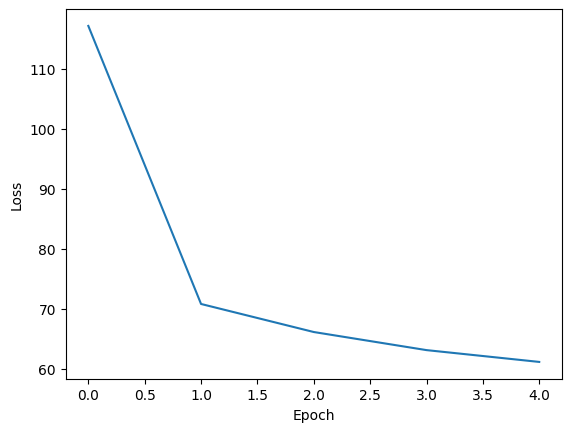

In [9]:
# Plot the loss history
plt.plot(loss_hist)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

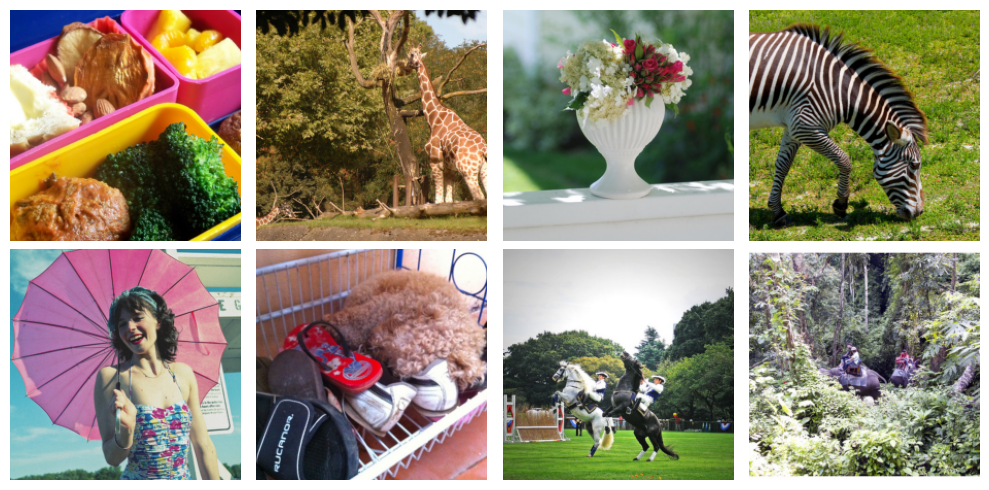

In [10]:
# Sample a few images from the dataset
images, _ = next(iter(train_dl))

# Plot the images
fig, axes = plt.subplots(2, 4, figsize=(10, 5))
for i, ax in enumerate(axes.flatten()):
    ax.imshow(images[i].permute(1, 2, 0))
    ax.axis('off')
plt.tight_layout()
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


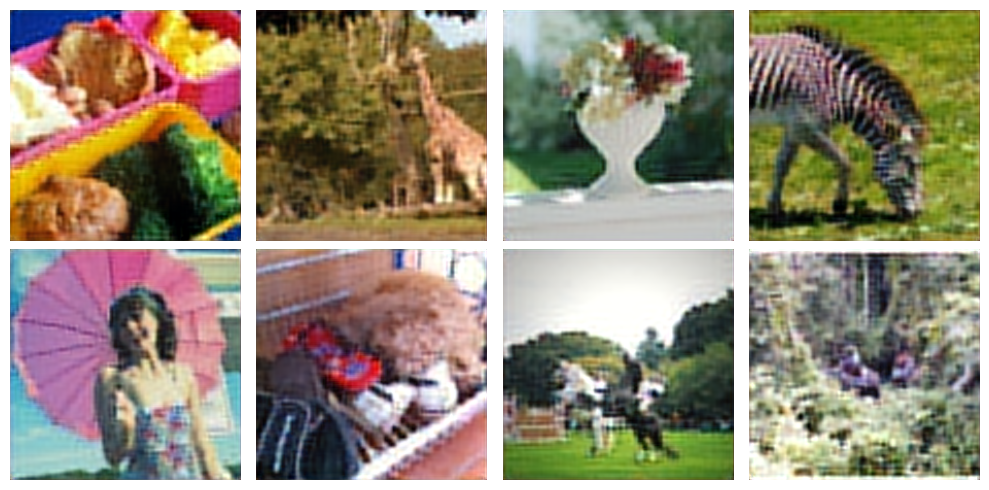

In [11]:
# Plot the reconstructed images
with torch.no_grad():
    images = images.to(device)
    outputs = autoencoder(images)
    outputs = outputs.cpu()
    fig, axes = plt.subplots(2, 4, figsize=(10, 5))
    for i, ax in enumerate(axes.flatten()):
        ax.imshow(outputs[i].permute(1, 2, 0))
        ax.axis('off')
    plt.tight_layout()
    plt.show()